**Goal of this notebook:**  
Understand the two cleaned datasets in depth so we can later build meaningful models and visualizations.

Datasets:
1) `employment_rate_clean.csv` — monthly employment rates by province, sex, and variable (1976–2019).  
2) `canadian_salary_data_clean.csv` — salary survey for Canada with Year, Company Size, Industry, Experience, Title, City, Salary (USD).

**What we’ll do:**
- Load & sanity-check both datasets  
- Salary dataset: distributions, outliers, pay by experience/industry/city/year/company size  
- Employment dataset: reshape to long format, yearly trends by province and sex  
- Save tidy aggregates for later notebooks

In [80]:
# Import Libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.figsize"] = (10,6)
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False

DATA_DIR = "../data/processed"
FIG_DIR = "../reports/figures"
os.makedirs(FIG_DIR, exist_ok=True)

salary = pd.read_csv(f"{DATA_DIR}/canadian_salary_data_clean.csv")
emp = pd.read_csv(f"{DATA_DIR}/employment_rate_clean.csv")
salary.head(), emp.head()

(   year          company_size  \
 0  2023    10 to 19 employees   
 1  2023  100 to 499 employees   
 2  2023    20 to 99 employees   
 3  2023    20 to 99 employees   
 4  2023  100 to 499 employees   
 
                                             industry        experience  \
 0  Information Services, IT, Software Development...      5 to 9 years   
 1     Manufacturing, Transportation, or Supply Chain  10 or more years   
 2  Information Services, IT, Software Development...      2 to 4 years   
 3     Manufacturing, Transportation, or Supply Chain      5 to 9 years   
 4  Information Services, IT, Software Development...      5 to 9 years   
 
                                            title country  salary_(usd)  \
 0  Data scientist or machine learning specialist  Canada       52046.0   
 1                          Developer, full-stack  Canada       64686.0   
 2                          Developer, full-stack  Canada       59481.0   
 3                       Data or business 

## Quick sanity checks
We confirm shapes, dtypes, and basic uniqueness to ensure the data loaded as expected.

In [81]:
print("Salary shape:", salary.shape)
print("Employment shape:", emp.shape)
print("\nSalary dtypes:\n", salary.dtypes)
print("\nEmployment dtypes:\n", emp.dtypes)

print("\nSalary years:", sorted(salary["year"].unique().tolist()))
print("Employment 'variable' values:", emp["variable"].unique())
print("Employment 'sex' values:", emp["sex"].unique())

Salary shape: (7038, 8)
Employment shape: (4743, 13)

Salary dtypes:
 year              int64
company_size     object
industry         object
experience       object
title            object
country          object
salary_(usd)    float64
city             object
dtype: object

Employment dtypes:
 month                         object
variable                      object
sex                           object
alberta                      float64
british_columbia             float64
manitoba                     float64
new_brunswick                float64
newfoundland_and_labrador    float64
nova_scotia                  float64
ontario                      float64
prince_edward_island         float64
quebec                       float64
saskatchewan                 float64
dtype: object

Salary years: [2011, 2012, 2013, 2014, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]
Employment 'variable' values: ['Employment' 'Full-time employment' 'Part-time employment ']
Employment 'sex' values: ['B

## SALARY DATASET — Column normalization & helpers
We’ll:
- Ensure `Year` is integer and `Salary (USD)` numeric  
- Parse **Company Size** into an approximate midpoint (numeric) to enable analysis  
- Create **ordered experience** → approximate years of experience  
- (No duplicates removal: duplicates were kept by design as survey frequency)

In [82]:
# Normalize key columns
salary["year"] = salary["year"].astype(int)

# Ensure salary numeric (already clean, but safe):
salary["salary_(usd)"] = pd.to_numeric(salary["salary_(usd)"], errors="coerce")

# Company size → midpoint
def parse_company_size(x: str):
    if pd.isna(x): return np.nan
    x = x.strip().lower()
    # examples seen: "2 to 9 employees", "10 to 19 employees", "500 to 999 employees", "1,000 to 4,999 employees"
    x = x.replace("employees","").replace(",","")
    parts = x.split("to")
    try:
        if len(parts)==2:
            a = int(parts[0].strip())
            b = int(parts[1].strip())
            return (a+b)/2
        # handle "10 or more years" style doesn't appear here; keep default
    except:
        return np.nan
    return np.nan

salary["companysize_mid"] = salary["company_size"].apply(parse_company_size)

# Experience → approximate years (ordered mapping)
exp_map = {
    "Less than 1 year": 0.5,
    "1 to 2 years": 1.5,
    "3 to 4 years": 3.5,
    "5 to 9 years": 7.0,
    "10 or more years": 12.0
}
salary["exp_years"] = salary["experience"].map(exp_map)

# Clean common text cols for consistency
for c in ["industry","title","city","country"]:
    salary[c] = salary[c].astype(str).str.strip()

salary.head()

,year,company_size,industry,experience,title,country,salary_(usd),city,companysize_mid,exp_years
0,2023,10 to 19 employees,"Information Services, IT, Software Development...",5 to 9 years,Data scientist or machine learning specialist,Canada,52046.0,Halifax,14.5,7.0
1,2023,100 to 499 employees,"Manufacturing, Transportation, or Supply Chain",10 or more years,"Developer, full-stack",Canada,64686.0,Montreal,299.5,12.0
2,2023,20 to 99 employees,"Information Services, IT, Software Development...",2 to 4 years,"Developer, full-stack",Canada,59481.0,Hamilton–Niagara Peninsula,59.5,NaN
3,2023,20 to 99 employees,"Manufacturing, Transportation, or Supply Chain",5 to 9 years,Data or business analyst,Canada,63199.0,Halifax,59.5,7.0
4,2023,100 to 499 employees,"Information Services, IT, Software Development...",5 to 9 years,"Developer, front-end",Canada,53533.0,Montreal,299.5,7.0


## SALARY — Detect & cap extreme outliers
Surveys often have heavy-tailed salaries. We’ll **winsorize** (cap) at the 1st/99th percentiles to prevent a few extreme values from dominating plots. We **do not** drop rows.

In [83]:
# Winsorize salary at 1st/99th percentiles (non-destructive cap)
p1, p99 = salary["salary_(usd)"].quantile([0.01, 0.99])
salary["salary_winsor"] = salary["salary_(usd)"].clip(lower=p1, upper=p99)
print(f"Winsor bounds: {p1:.0f}–{p99:.0f}")

Winsor bounds: 28588–107810


## SALARY — Distribution
We check the (winsorized) salary distribution and a log-scale version to reveal structure.

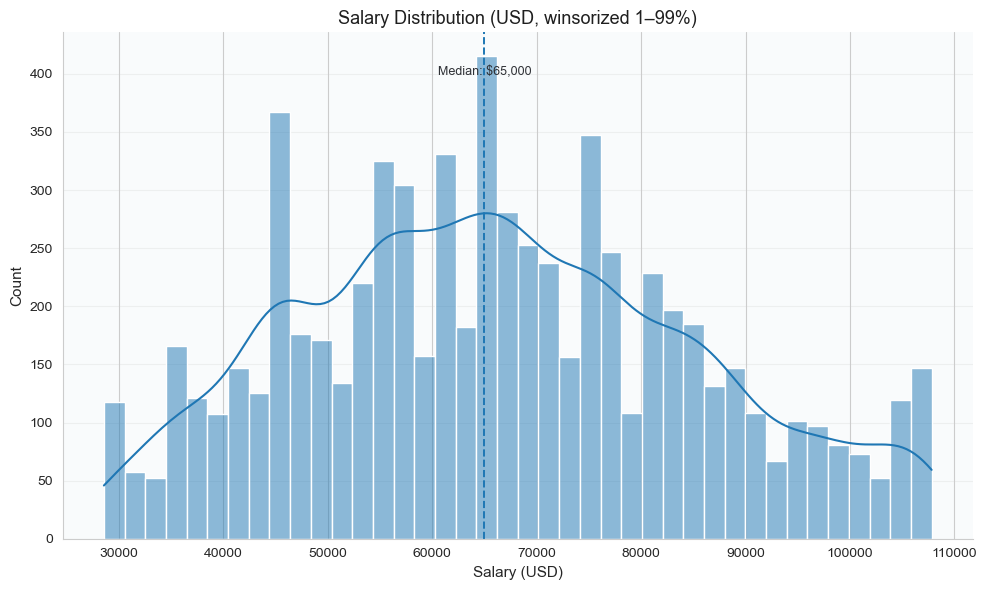

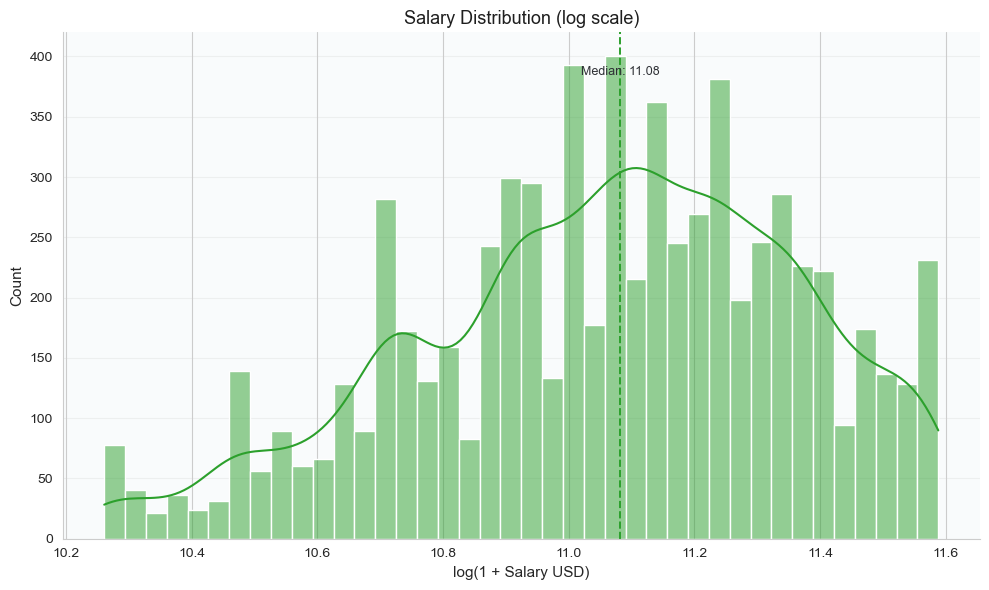

In [84]:
palette = {"linear": "#1f77b4", "log": "#2ca02c"}
salary_linear = salary["salary_winsor"]
salary_log = np.log1p(salary_linear)

with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots()
    sns.histplot(salary_linear, bins=40, kde=True, ax=ax,
                 color=palette["linear"], edgecolor="white")
    median_salary = salary_linear.median()
    ax.axvline(median_salary, color=palette["linear"], linestyle="--", linewidth=1.4)
    ax.annotate(f"Median: ${median_salary:,.0f}", xy=(median_salary, ax.get_ylim()[1]*0.9),
                xytext=(0, 6), textcoords="offset points", ha="center", color="#2f3136", fontsize=9)
    ax.set_title("Salary Distribution (USD, winsorized 1–99%)", fontsize=13, color="#1f1f1f")
    ax.set_xlabel("Salary (USD)", fontsize=11)
    ax.set_ylabel("Count", fontsize=11)
    ax.set_facecolor("#f9fbfc")
    ax.grid(axis="y", alpha=0.25)
    sns.despine()
    plt.tight_layout()
    plt.savefig(f"{FIG_DIR}/salary_distribution.png", dpi=300)
    plt.show()

with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots()
    sns.histplot(salary_log, bins=40, kde=True, ax=ax,
                 color=palette["log"], edgecolor="white")
    median_log = salary_log.median()
    ax.axvline(median_log, color=palette["log"], linestyle="--", linewidth=1.4)
    ax.annotate(f"Median: {median_log:.2f}", xy=(median_log, ax.get_ylim()[1]*0.9),
                xytext=(0, 6), textcoords="offset points", ha="center", color="#2f3136", fontsize=9)
    ax.set_title("Salary Distribution (log scale)", fontsize=13, color="#1f1f1f")
    ax.set_xlabel("log(1 + Salary USD)", fontsize=11)
    ax.set_ylabel("Count", fontsize=11)
    ax.set_facecolor("#f9fbfc")
    ax.grid(axis="y", alpha=0.25)
    sns.despine()
    plt.tight_layout()
    plt.savefig(f"{FIG_DIR}/salary_distribution_log.png", dpi=300)
    plt.show()

## SALARY — Salary over time
We summarize central tendency and spread by **Year**.

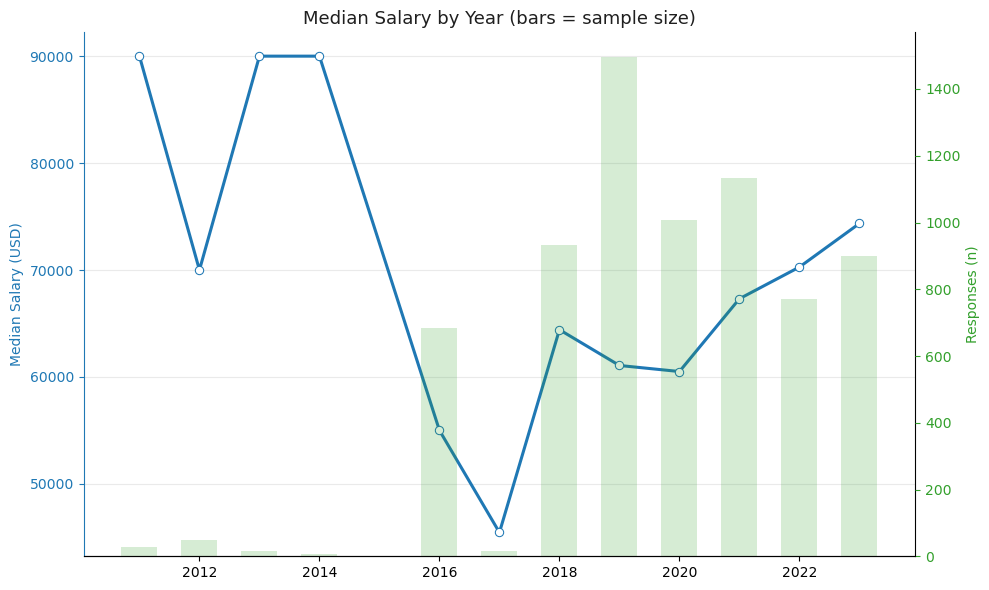

,year,median_salary,mean_salary,n
0,2011,90000.0,83102.142857,28
1,2012,70000.0,76643.283958,48
2,2013,90000.0,78895.333333,15
3,2014,90000.0,86678.750000,8
4,2016,55000.0,60250.568161,685


In [85]:
# Yearly summary
yr = (salary
      .groupby("year", as_index=False)
      .agg(median_salary=("salary_winsor", "median"),
           mean_salary=("salary_winsor", "mean"),
           n=("salary_winsor", "size")))

line_color, bar_color = "#1f78b4", "#33a02c"

fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(data=yr, x="year", y="median_salary", marker="o",
             markerfacecolor="white", markeredgecolor=line_color,
             linewidth=2.2, color=line_color, ax=ax)
ax.set_facecolor("white")
ax.grid(axis="y", color="#eaeaea")
ax.set_title("Median Salary by Year (bars = sample size)", fontsize=13, color="#1f1f1f")
ax.set_xlabel("")
ax.set_ylabel("Median Salary (USD)", color=line_color)
ax.tick_params(axis="y", colors=line_color)

ax2 = ax.twinx()
ax2.bar(yr["year"], yr["n"], color=bar_color, alpha=0.2, width=0.6)
ax2.set_ylabel("Responses (n)", color=bar_color)
ax2.tick_params(axis="y", colors=bar_color)
ax2.grid(False)

ax.spines["left"].set_color(line_color)
ax2.spines["right"].set_color(bar_color)
sns.despine(ax=ax, right=False)
sns.despine(ax=ax2, left=True)

plt.tight_layout()
plt.savefig(f"{FIG_DIR}/salary_by_year.png", dpi=300)
plt.show()

yr.head()

## SALARY — Salary by experience
We expect a strong monotonic increase with experience.

C:\Users\87114\AppData\Local\Temp\ipykernel_6400\812157369.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


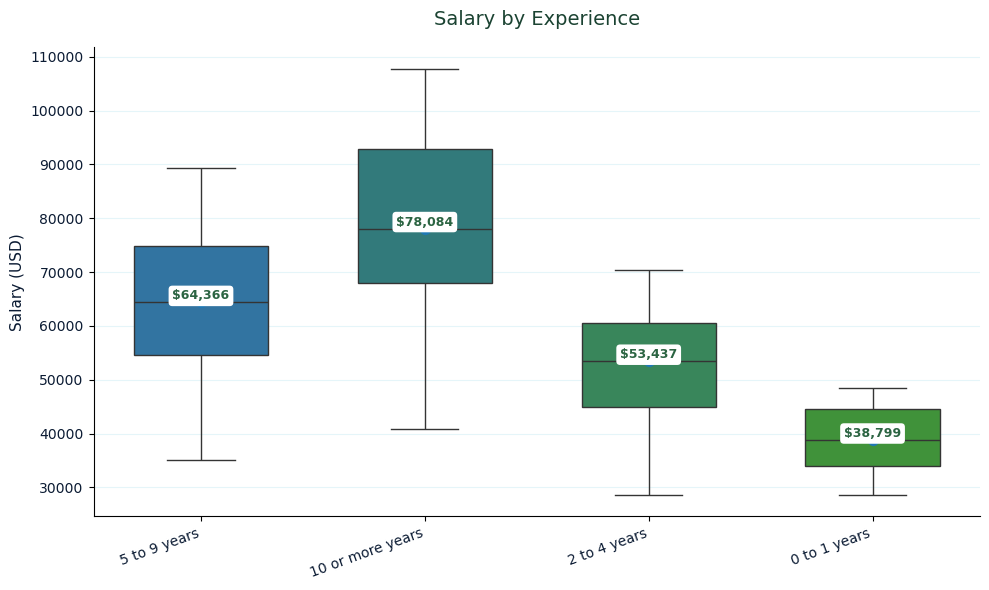

experience
10 or more years    78084.0
5 to 9 years        64365.5
2 to 4 years        53437.0
0 to 1 years        38799.0
Name: salary_winsor, dtype: float64

In [ ]:
# Experience vs salary
order_exp = sorted(
    salary["experience"].dropna().unique(),
    key=lambda x: exp_map.get(x, np.inf)
)

palette_exp = sns.color_palette("blend:#1f78b4,#33a02c", n_colors=len(order_exp))
median_exp = salary.groupby("experience")["salary_winsor"].median()

fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(
    data=salary,
    x="experience",
    y="salary_winsor",
    order=order_exp,
    palette=palette_exp,
    width=0.6,
    ax=ax
)

ax.set_title("Salary by Experience", fontsize=14, color="#1b4332", pad=16)
ax.set_xlabel("")
ax.set_ylabel("Salary (USD)", fontsize=11, color="#0b1b33")
ax.set_facecolor("white")
ax.grid(axis="y", color="#e5f5f9", linewidth=0.8)
sns.despine(ax=ax)

for idx, exp in enumerate(order_exp):
    med = median_exp.get(exp)
    if pd.notna(med):
        ax.scatter(idx, med, color="#1f78b4", s=50, zorder=3)
        ax.text(
            idx,
            med,
            f"${med:,.0f}",
            ha="center",
            va="bottom",
            fontsize=9,
            color="#14532d",
            weight="bold",
            alpha=0.9,
            bbox=dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor="none")
        )

plt.xticks(rotation=20, ha="right", color="#0b1b33")
plt.yticks(color="#0b1b33")
plt.tight_layout()
plt.savefig(f"{FIG_DIR}/salary_by_experience.png", dpi=300, facecolor="white")
plt.show()

median_exp.sort_values(ascending=False)

## SALARY — Salary by industry (Top 10 by sample size)
We show variability across industries but avoid tiny groups.

C:\Users\87114\AppData\Local\Temp\ipykernel_6400\1421073345.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


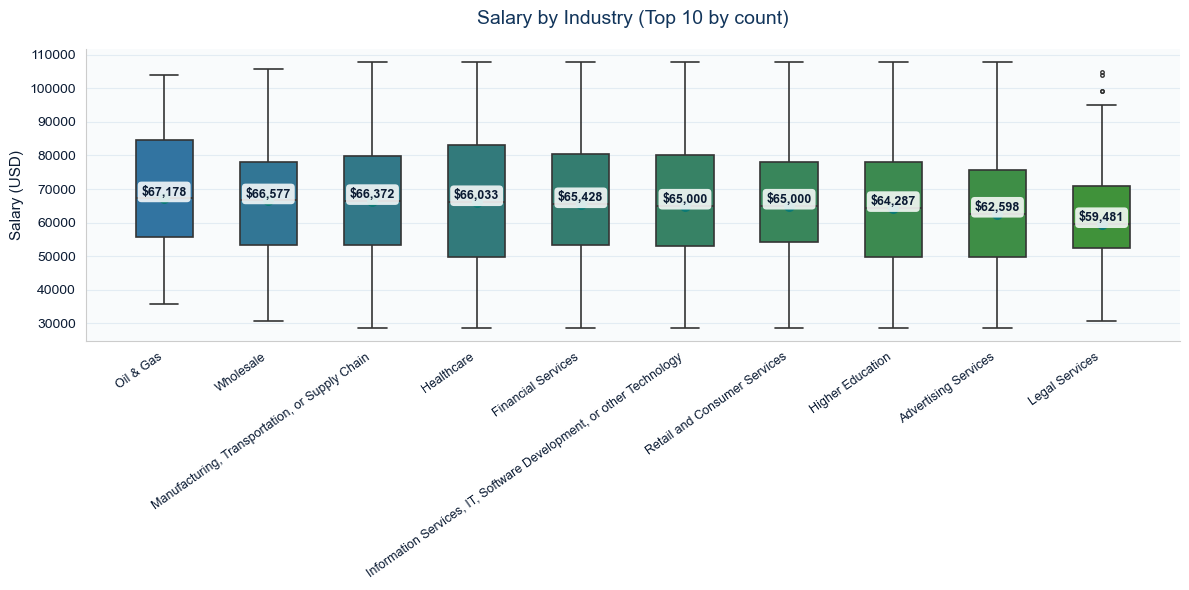

industry
Oil & Gas                                                              67178.0
Wholesale                                                              66577.0
Manufacturing, Transportation, or Supply Chain                         66372.0
Healthcare                                                             66033.0
Financial Services                                                     65428.5
Information Services, IT, Software Development, or other Technology    65000.0
Retail and Consumer Services                                           65000.0
Higher Education                                                       64287.0
Advertising Services                                                   62598.0
Legal Services                                                         59481.0
Name: salary_winsor, dtype: float64

In [87]:
# Industry comparison
top_ind = salary["industry"].value_counts().head(10).index
subset_ind = salary[salary["industry"].isin(top_ind)].copy()

median_ind = (subset_ind.groupby("industry")["salary_winsor"]
              .median()
              .sort_values(ascending=False))
order_ind = median_ind.index
palette_ind = sns.color_palette("blend:#1f78b4,#33a02c", n_colors=len(order_ind))

with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(12, 6))
    sns.boxplot(
        data=subset_ind,
        x="industry",
        y="salary_winsor",
        order=order_ind,
        palette=palette_ind,
        width=0.55,
        fliersize=2.5,
        linewidth=1.2,
        ax=ax,
    )
    ax.set_title("Salary by Industry (Top 10 by count)", fontsize=14, color="#12355b", pad=18)
    ax.set_xlabel("")
    ax.set_ylabel("Salary (USD)", fontsize=11, color="#0b1b33")
    ax.set_facecolor("#f9fbfc")
    ax.grid(axis="y", color="#e3ecf3", linewidth=0.8)
    sns.despine(ax=ax)

    for idx, (industry, median_val) in enumerate(median_ind.items()):
        ax.scatter(idx, median_val, color="#0b7a75", s=48, zorder=3)
        ax.text(
            idx,
            median_val,
            f"${median_val:,.0f}",
            ha="center",
            va="bottom",
            fontsize=9,
            color="#0b1b33",
            weight="bold",
            bbox=dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor="none", alpha=0.85),
        )

    plt.xticks(rotation=35, ha="right", fontsize=9, color="#0b1b33")
    plt.yticks(color="#0b1b33")
    plt.tight_layout()
    plt.savefig(f"{FIG_DIR}/salary_by_industry.png", dpi=300, facecolor="white")
    plt.show()

median_ind.head(10)

## SALARY — Salary by city (Top 10 by sample size)
Gives a sense of regional differences inside Canada (survey-based).

C:\Users\87114\AppData\Local\Temp\ipykernel_6400\3112115151.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


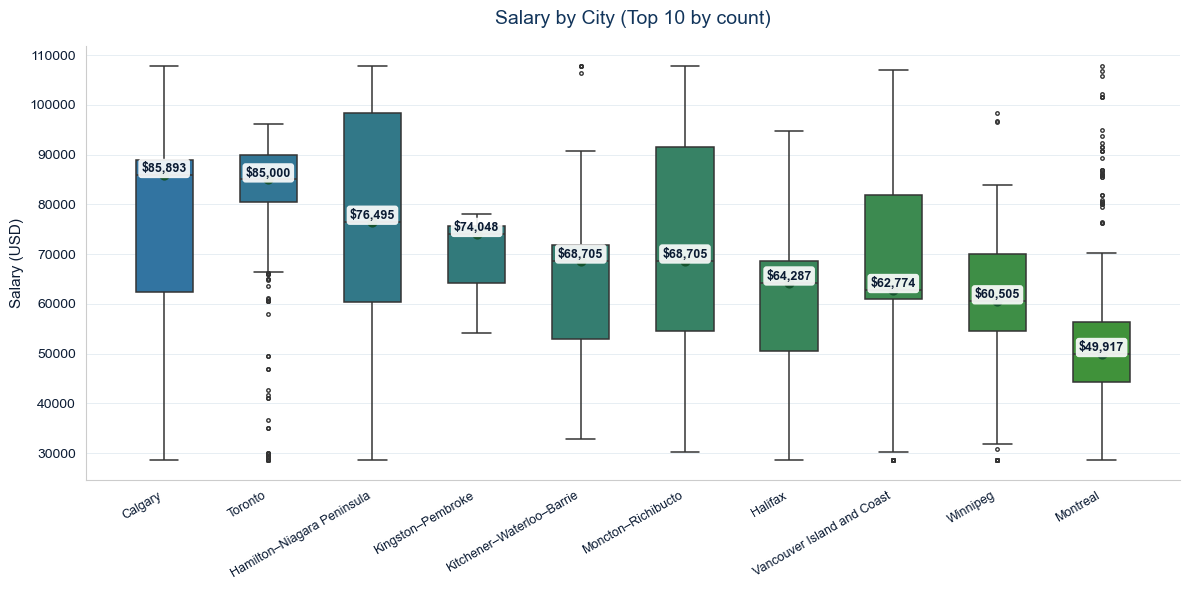

city
Calgary                       85893.0
Toronto                       85000.0
Hamilton–Niagara Peninsula    76495.0
Kingston–Pembroke             74048.0
Kitchener–Waterloo–Barrie     68705.0
Moncton–Richibucto            68705.0
Halifax                       64287.0
Vancouver Island and Coast    62774.0
Winnipeg                      60505.0
Montreal                      49917.0
Name: salary_winsor, dtype: float64

In [88]:
# City comparison (polished)
top_city = salary["city"].value_counts().head(10).index
subset_city = salary[salary["city"].isin(top_city)].copy()

median_city = (subset_city.groupby("city")["salary_winsor"]
               .median()
               .sort_values(ascending=False))
order_city = median_city.index
palette_city = sns.color_palette("blend:#1f78b4,#33a02c", n_colors=len(order_city))

with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(12, 6))
    sns.boxplot(
        data=subset_city,
        x="city",
        y="salary_winsor",
        order=order_city,
        palette=palette_city,
        width=0.55,
        linewidth=1.1,
        fliersize=2.5,
        ax=ax,
    )

    for idx, (city, med_val) in enumerate(median_city.items()):
        ax.scatter(idx, med_val, color="#14532d", s=40, zorder=3)
        ax.text(
            idx,
            med_val,
            f"${med_val:,.0f}",
            ha="center",
            va="bottom",
            fontsize=9,
            color="#0b1b33",
            weight="bold",
            bbox=dict(boxstyle="round,pad=0.25", facecolor="white", edgecolor="none", alpha=0.9),
        )

    ax.set_title("Salary by City (Top 10 by count)", fontsize=14, color="#12355b", pad=16)
    ax.set_xlabel("")
    ax.set_ylabel("Salary (USD)", fontsize=11, color="#0b1b33")
    ax.set_facecolor("white")
    ax.grid(axis="y", color="#d7e3eb", linewidth=0.7, alpha=0.6)
    sns.despine(ax=ax)

    plt.xticks(rotation=30, ha="right", fontsize=9, color="#0b1b33")
    plt.yticks(color="#0b1b33")
    plt.tight_layout()
    plt.savefig(f"{FIG_DIR}/salary_by_city.png", dpi=300, facecolor="white")
    plt.show()

median_city.head(10)

## SALARY — Company size & salary
We use the midpoint of the size bracket as a proxy.

C:\Users\87114\AppData\Local\Temp\ipykernel_6400\3707675458.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


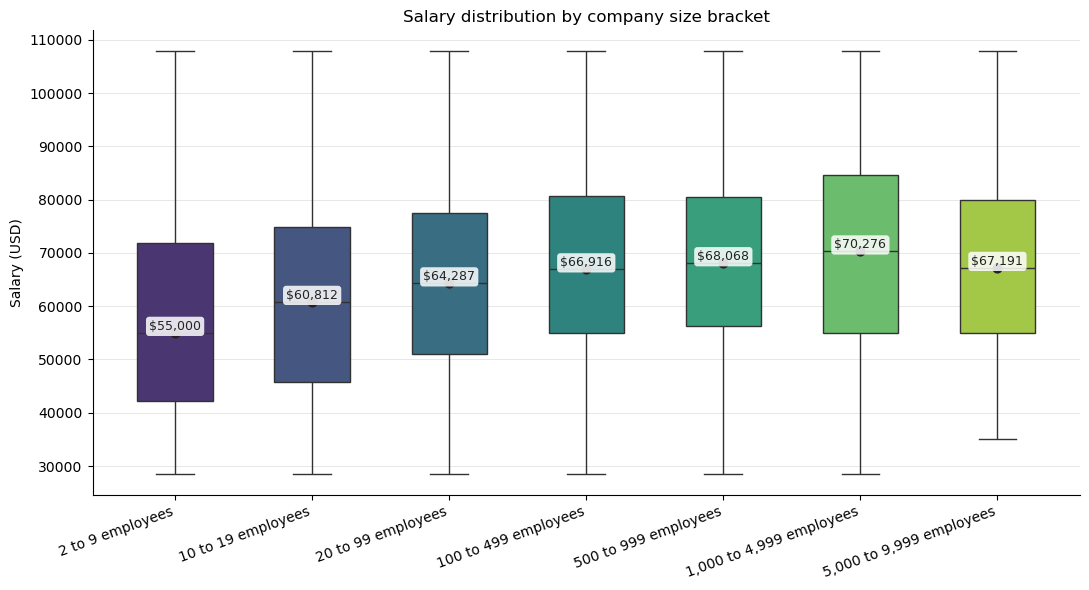

,company_size,midpoint,median_salary,q1,q3,n
4,2 to 9 employees,5.5,55000.0,42228.0,71850.00,573
1,10 to 19 employees,14.5,60812.0,45803.0,74875.00,726
5,20 to 99 employees,59.5,64287.0,51051.0,77489.00,1649
3,100 to 499 employees,299.5,66916.0,55000.0,80690.00,1651
7,500 to 999 employees,749.5,68068.0,56365.0,80521.00,485
0,"1,000 to 4,999 employees",2999.5,70276.0,55000.0,84707.00,764
6,"5,000 to 9,999 employees",7499.5,67191.0,55000.0,79853.25,338
2,"10,000 or more employees",NaN,66916.0,55000.0,80925.00,852


In [89]:
# Company size vs salary — distribution by bracket
size_order = (
    salary.dropna(subset=["companysize_mid"])
    .groupby("company_size")["companysize_mid"]
    .mean()
    .sort_values()
    .index
)

medians_by_size = salary.groupby("company_size")["salary_winsor"].median()

fig, ax = plt.subplots(figsize=(11, 6))
sns.boxplot(
    data=salary,
    x="company_size",
    y="salary_winsor",
    order=size_order,
    palette=sns.color_palette("viridis", n_colors=len(size_order)),
    ax=ax,
    fliersize=2.5,
    width=0.55,
)

for idx, label in enumerate(size_order):
    ax.scatter(idx, medians_by_size[label], color="#222", s=40, zorder=3)
    ax.text(
        idx,
        medians_by_size[label],
        f"${medians_by_size[label]:,.0f}",
        ha="center",
        va="bottom",
        fontsize=9,
        color="#222",
        bbox=dict(boxstyle="round,pad=0.25", facecolor="white", edgecolor="none", alpha=0.85),
    )

ax.set_title("Salary distribution by company size bracket")
ax.set_xlabel("")
ax.set_ylabel("Salary (USD)")
ax.set_facecolor("white")
ax.grid(axis="y", color="#e0e0e0", linewidth=0.7, alpha=0.8)
plt.xticks(rotation=20, ha="right")
sns.despine(ax=ax)
plt.tight_layout()
plt.savefig(f"{FIG_DIR}/salary_vs_companysize.png", dpi=300)
plt.show()

size_summary = (
    salary.groupby("company_size", as_index=False)
    .agg(
        midpoint=("companysize_mid", "mean"),
        median_salary=("salary_winsor", "median"),
        q1=("salary_winsor", lambda x: np.percentile(x, 25)),
        q3=("salary_winsor", lambda x: np.percentile(x, 75)),
        n=("salary_winsor", "size"),
    )
    .sort_values("midpoint")
)

size_summary

---
# EMPLOYMENT DATASET — Reshape & explore

The employment file is wide by provinces. We will:
- Convert `month` to datetime and extract `year`  
- Melt province columns into long format (`province`, `employment_rate`)  
- Explore yearly trends by province and by sex

In [90]:
# Prepare employment (long format)
emp = emp.copy()
emp["month"] = pd.to_datetime(emp["month"])  # expected monthly string; if already parsed, this is safe
emp["year"] = emp["month"].dt.year

# province columns start after ['month','variable','sex']
province_cols = [c for c in emp.columns if c not in ["month","variable","sex","year"]]
emp_long = emp.melt(
    id_vars=["month","year","variable","sex"],
    value_vars=province_cols,
    var_name="province",
    value_name="employment_rate"
)

# Keep the main variable if multiple exist (often it's already employment rate)
# If your 'variable' has only one value, this is a no-op.
if emp_long["variable"].nunique() > 1:
    print("Available variables:", emp_long["variable"].unique())

emp_long.head()

Available variables: ['Employment' 'Full-time employment' 'Part-time employment ']


,month,year,variable,sex,province,employment_rate
0,1976-01-01,1976,Employment,Both sexes,alberta,819.5
1,1976-01-01,1976,Employment,Females,alberta,307.1
2,1976-01-01,1976,Employment,Males,alberta,512.5
3,1976-01-01,1976,Full-time employment,Both sexes,alberta,693.7
4,1976-01-01,1976,Full-time employment,Females,alberta,217.9


## EMPLOYMENT — Yearly trends by province (all sexes)
We average monthly values by year and province to smooth the seasonality.

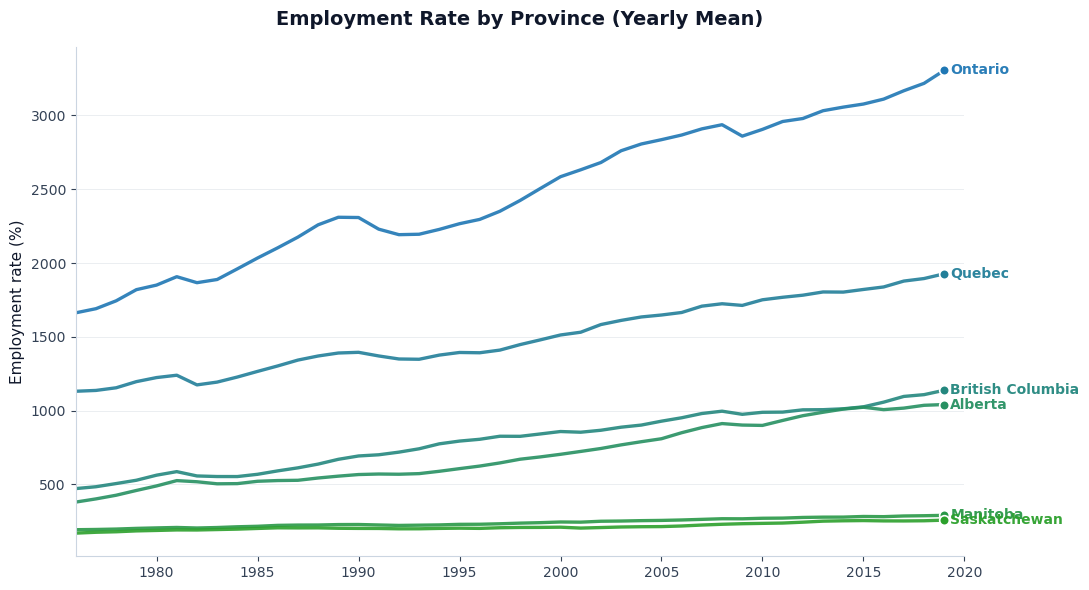

,year,province,employment_rate
435,2019,nova_scotia,207.143434
436,2019,ontario,3305.690909
437,2019,prince_edward_island,34.489899
438,2019,quebec,1927.265657
439,2019,saskatchewan,257.816162


In [91]:
# Province trends (yearly) — minimalist blue/green styling with inline labels
prov_year = (emp_long
             .groupby(["year", "province"], as_index=False)["employment_rate"]
             .mean())

recent = prov_year[prov_year["year"] >= prov_year["year"].max() - 10]
top_now = (recent[recent["year"] == recent["year"].max()]
           .sort_values("employment_rate", ascending=False)["province"]
           .head(6)
           .tolist())

palette_prov = sns.color_palette("blend:#1f77b4,#2ca02c", n_colors=len(top_now))

with sns.axes_style("ticks"):
    fig, ax = plt.subplots(figsize=(11, 6))

    for color, province in zip(palette_prov, top_now):
        sub = prov_year[prov_year["province"] == province]
        label = province.replace("_", " ").title()

        ax.plot(sub["year"], sub["employment_rate"],
                color=color, linewidth=2.4, alpha=0.9)

        last_year_val = sub.iloc[-1]
        ax.scatter(last_year_val["year"], last_year_val["employment_rate"],
                   color=color, s=48, edgecolor="white", linewidth=1.2, zorder=3)

        ax.text(last_year_val["year"] + 0.3, last_year_val["employment_rate"],
                label, color=color, fontsize=10, fontweight="bold",
                ha="left", va="center", alpha=0.95)

    ax.set_xlim(prov_year["year"].min(), prov_year["year"].max() + 1)
    ax.set_title("Employment Rate by Province (Yearly Mean)",
                 fontsize=14, color="#0f172a", pad=16, fontweight="bold")
    ax.set_xlabel("")
    ax.set_ylabel("Employment rate (%)", color="#0f172a", fontsize=11)
    ax.grid(axis="y", color="#d0d7de", linewidth=0.6, alpha=0.5)
    ax.set_facecolor("white")
    ax.tick_params(colors="#334155", labelsize=10)
    for spine in ["top", "right"]:
        ax.spines[spine].set_visible(False)
    for spine in ["left", "bottom"]:
        ax.spines[spine].set_color("#cbd5e1")

plt.tight_layout()
plt.savefig(f"{FIG_DIR}/employment_rate_by_province.png", dpi=300, facecolor="white")
plt.show()

prov_year.tail()

## EMPLOYMENT — Yearly trends by sex (national mean)
We average across provinces to get a national-level view, split by sex.

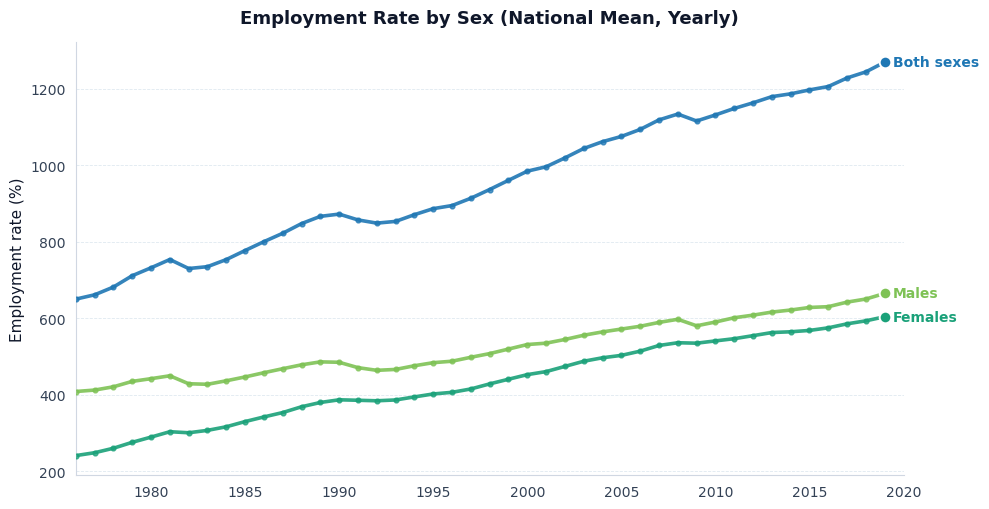

,year,sex,employment_rate
127,2018,Females,593.432778
128,2018,Males,650.416389
129,2019,Both sexes,1269.271515
130,2019,Females,604.161212
131,2019,Males,665.105152


In [ ]:
# Sex trends (national, refreshed styling)
sex_year = (emp_long
            .groupby(["year", "sex"], as_index=False)["employment_rate"]
            .mean())

sex_order = [s for s in ["Both sexes", "Females", "Males"] if s in sex_year["sex"].unique()]
palette_sex = {
    "Both sexes": "#1f77b4",   # deep blue
    "Females": "#1aa179",      # teal
    "Males": "#7ec255"         # soft green
}

with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize=(10, 5.2))

    for sex_name in sex_order:
        sub = sex_year[sex_year["sex"] == sex_name]
        color = palette_sex[sex_name]
        ax.plot(sub["year"], sub["employment_rate"],
                color=color, linewidth=2.6, alpha=0.9, label=sex_name)
        ax.scatter(sub["year"], sub["employment_rate"],
                   color=color, s=12, alpha=0.75, zorder=3)

    last_pts = (sex_year.sort_values("year")
                .groupby("sex", as_index=False)
                .last())

    for _, row in last_pts.iterrows():
        color = palette_sex.get(row["sex"], "#64748b")
        ax.scatter(row["year"], row["employment_rate"],
                   color=color, s=70, edgecolor="white", linewidth=1.4, zorder=4)
        ax.text(row["year"] + 0.45, row["employment_rate"],
                row["sex"], color=color, fontsize=10, weight="bold",
                ha="left", va="center",
                bbox=dict(boxstyle="round,pad=0.28", facecolor="white", edgecolor="none", alpha=0.9))

    ax.set_xlim(sex_year["year"].min(), sex_year["year"].max() + 1)
    ax.set_title("Employment Rate by Sex (National Mean, Yearly)",
                 fontsize=13, color="#0f172a", pad=14, weight="bold")
    ax.set_xlabel("")
    ax.set_ylabel("Employment rate (%)", fontsize=11, color="#0f172a")
    ax.grid(axis="y", color="#d7e3ed", linewidth=0.6, alpha=0.8, linestyle="--")
    ax.tick_params(colors="#334155")
    ax.spines["left"].set_color("#d0d7e2")
    ax.spines["bottom"].set_color("#d0d7e2")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

plt.tight_layout()
plt.savefig(f"{FIG_DIR}/employment_rate_by_sex.png", dpi=300, facecolor="white")
plt.show()

sex_year.tail()


## EMPLOYMENT — Province league table (last available year)
Gives a snapshot of which provinces are currently highest/lowest.

In [ ]:
# Last-year ranking
last_year = prov_year["year"].max()
rank_last = (prov_year[prov_year["year"]==last_year]
             .sort_values("employment_rate", ascending=False))
rank_last.reset_index(drop=True).head(20)

,year,province,employment_rate
0,2019,ontario,3305.690909
1,2019,quebec,1927.265657
2,2019,british_columbia,1138.010101
3,2019,alberta,1041.336364
4,2019,manitoba,290.460606
5,2019,saskatchewan,257.816162
6,2019,nova_scotia,207.143434
7,2019,new_brunswick,158.474747
8,2019,newfoundland_and_labrador,101.105051
9,2019,prince_edward_island,34.489899


## Tidy aggregates to reuse later
We save a few tidy tables for modeling/visualization:
- `salary_year.csv` — median/mean salary by year  
- `salary_experience.csv` — median salary by experience  
- `salary_industry_top10.csv` — medians for top 10 industries  
- `salary_city_top10.csv` — medians for top 10 cities  
- `employment_province_year.csv` — yearly employment rate by province  
- `employment_sex_year.csv` — yearly national employment rate by sex

In [ ]:
# Save aggregates
OUT = "../data/processed"

yr.to_csv(f"{OUT}/salary_year.csv", index=False)

sal_exp = (salary.groupby("experience", as_index=False)["salary_winsor"]
           .median().rename(columns={"salary_winsor":"median_salary"}))
sal_exp.to_csv(f"{OUT}/salary_experience.csv", index=False)

sal_ind = (subset_ind.groupby("industry", as_index=False)["salary_winsor"]
           .median().rename(columns={"salary_winsor":"median_salary"}))
sal_ind.to_csv(f"{OUT}/salary_industry_top10.csv", index=False)

sal_city = (subset_city.groupby("city", as_index=False)["salary_winsor"]
            .median().rename(columns={"salary_winsor":"median_salary"}))
sal_city.to_csv(f"{OUT}/salary_city_top10.csv", index=False)

prov_year.to_csv(f"{OUT}/employment_province_year.csv", index=False)
sex_year.to_csv(f"{OUT}/employment_sex_year.csv", index=False)

print("Aggregates saved to data/processed/")

✅ Aggregates saved to data/processed/


## Key EDA takeaways (to revisit later)
- Salary distributions are heavy-tailed → winsorization helps visualize.  
- Salary rises clearly with **experience**; strong group differences across **industry** and **city**.  
- Median salary trend over **Year** may be weak/moderate depending on sample size per year.  
- Employment rates vary by **province** and **sex**, with clear time dynamics.

**Next notebook:** `03_visualizations.ipynb` to craft polished charts for the report, then `04_modeling.ipynb`.